**Импорты внешних модулей и библиотек**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
from glob import glob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

**Объявление функций**

In [2]:
def regions(regions, names):
    regs = list(dict(regions.value_counts()).items())
    regs = [i[0] for i in regs if i[1] >= 5]

    words = [
             'автономный', 'округ', 'край', 'город',
             'республика', 'область', 'обл', 'обл.',
             'г', 'г.', 'респ', 'респ.'
    ]
    regs_modified = []
    for s in regs:
        s = s.lower().strip().replace('/', '').replace('(', '').replace(')', '')
        s = s.split()
        for i in words:
            try:
                del s[s.index(i)]
            except:
                continue
        regs_modified.append(s[0])

    names = list(set(names))

    regs_names = []
    for i in range(len(regs_modified)):
        rm = regs_modified[i]
        if len(rm) < 10: rm = rm[:-2]
        else: rm = rm[:-4]
        count = 0
        for j in range(len(names)):
            if rm in names[j].lower() and count == 0:
                regs_names.append(names[j])
                count += 1
                break
        if count == 0:
            regs_names.append(None)

    return pd.DataFrame({'regions': regs, 'names': regs_names}) 

def income(income):
    inc = []
    for i in income:
        if len(str(i).strip().replace(' ', '')) > 3:
            try:
                inc.append(float(i))
            except:
                inc.append(None)
        else:
            inc.append(None)
    return inc

def print_info(df):
    print('Кол-во исходов в консолидированной выборке: {}'.format(df.shape[0]))
    print('Кол-во положительных исходов: {}'.format(df[df['default'] == 0].shape[0]))
    print('Кол-во отрицательных исходов: {}'.format(df[df['default'] == 1].shape[0]))

def gather(files, field):
    dfs = []
    for i in range(len(files)):
        df_tmp = pd.read_csv(files[i], sep = ';', skiprows = 1, names = ['DogNum', field])
        dfs.append(df_tmp)
    df = pd.concat(dfs)
    df.drop_duplicates(subset = ['DogNum'], inplace = True)
    df.dropna(inplace = True)
    return df

def col_names():
    return {
        'Кол-во кредитов со статусом "Активный" (тип кредита - любой, кроме "Микрокредит")':    'Active_exceptfor_micro',
        'Кол-во кредитов со статусом "Счет Закрыт" (тип кредита - любой, кроме "Микрокредит")': 'Closed_exceptfor_micro',
        'Кол-во кредитов со статусом "Просрочен" (тип кредита - любой, кроме "Микрокредит") ':  'Overdue_exceptfor_micro',
        'Кол-во кредитов со статусом "Счет закрыт - переведён в другой банк" (тип кредита - любой, кроме "Микрокредит")':\
                                                                                                'Closed_trans_exceptfor_micro',
        'Кол-во кредитов со статусом "Активный" (тип кредита - "Микрокредит")':    'Active_micro',
        'Кол-во кредитов со статусом "Счет Закрыт" (тип кредита - "Микрокредит")': 'Closed_micro',
        'Кол-во кредитов со статусом "Просрочен" (тип кредита - "Микрокредит")':   'Overdue_micro',
        'Кол-во кредитов со статусом "Счет закрыт - переведён в другой банк" (тип кредита - "Микрокредит")':\
                                                                                   'Closed_trans_micro',
        'Просрочено (по всем кредитам)': 'Overdue_all',
        'Число просрочек до 30 дней (по всем кредитам)':      'Num_overdue_all_30',
        'Число просрочек до 60 дней (по всем кредитам)':      'Num_overdue_all_60',
        'Число просрочек до 90 дней (по всем кредитам)':      'Num_overdue_all_90',
        'Число просрочек до 120 дней (по всем кредитам)':     'Num_overdue_all_120',
        'Число просрочек более 120 дней (по всем кредитам)':  'Num_overdue_all_120plus',
        'След. платеж (по всем кредитам)':                    'Next_payment',
        'Минимальная сумма кредита со статусом "Просрочен" ': 'Minsum_overdue',
        'Кол-во запросов в НБКИ за последние 30 дней':        'Num_request',
        'Качество прошлой КИ':                                'Credithistory_quality',
        'Доля активных договоров с просрочками':              'Fraqactive_overdue',
        'Доля закрытых договоров с просрочками':              'Fraqclosed_overdue',
        'Сумма просрочек до 30 дней (по всем кредитам)':      'Sum_overdue_all_30',
        'Сумма просрочек до 60 дней (по всем кредитам)':      'Sum_overdue_all_60',
        'Сумма просрочек до 90 дней (по всем кредитам)':      'Sum_overdue_all_90',
        'Сумма просрочек до 120 дней (по всем кредитам)':     'Sum_overdue_all_120',
        'Сумма просрочек более 120 дней (по всем кредитам)':  'Sum_overdue_all_120plus',
    }

**Формирование выборки и предобработка данных**

In [3]:
path = os.getcwd()
path_opr = os.path.join(os.path.split(os.getcwd())[0], 'metrics\data\opr')
path_zvk = os.path.join(os.path.split(os.getcwd())[0], 'metrics\data\zvk')

f = glob('\\'.join([path, 'data', 'halfYear', '*.csv']))
hlf = [_ for _ in f if 'analytics' in _]
bal = [_ for _ in f if 'accounting' in _]

f = glob('\\'.join([path, 'data', 'equifax', '*.csv']))
equi = [_ for _ in f if 'Requests' in _]

f = glob('\\'.join([path, 'data', 'features', '*.csv']))
regs = [_ for _ in f if 'regions' in _]
edu  = [_ for _ in f if 'education' in _]
marg = [_ for _ in f if 'marriage' in _]
inc  = [_ for _ in f if 'income' in _]

In [ ]:
dfopr = pd.read_csv('\\'.join([path_opr, 'opr_merger_report_.csv']), sep = ';', encoding = 'cp1251',
                                                                                parse_dates = ['Дата выполнения'])
dfzvk = pd.read_csv('\\'.join([path_zvk, 'zvk_merger_report_.csv']), sep = ';', encoding = 'cp1251',
                                                                                parse_dates = ['Дата рождения клиента'])

In [ ]:
dfs = []
for i in range(len(equi)):
    df_tmp = pd.read_csv(equi[i], sep = ';', encoding = 'cp1251')
    dfs.append(df_tmp)
df_equi = pd.concat(dfs)
df_equi.rename(columns = {'Номер договора': 'DogNum'}, inplace = True)
df_equi.dropna(subset = ['DogNum'], inplace = True)
df_equi['type'] = list(map(lambda x: 'online' if 'ON' in x else 'offline', df_equi['DogNum']))
df_equi = df_equi[df_equi['type'] == 'online']
df_equi.drop_duplicates(subset = ['DogNum'], inplace = True)
df_equi.fillna(value = 0, inplace = True)
print('Кол-во строк в консолидированном отчете: {}'.format(df_equi.shape[0]))

In [ ]:
dfs = []
cols1 = ['номер договора', 'дата выдачи займа', 'статус', 'число дней просрочки']
for i in range(len(hlf)):
    df_tmp = pd.read_csv(hlf[i], sep = ';', usecols = cols1, encoding = 'cp1251',
                                                             parse_dates = ['дата выдачи займа'], dayfirst = True)
    df_tmp['Дата отчета'] = pd.to_datetime(hlf[i].split('[')[1][:-1], yearfirst = True)
    dfs.append(df_tmp)
df_hlf = pd.concat(dfs)

dfs = []
cols2 = ['Номер договора', 'Дата договора', 'Статус', 'Количество дней просрочки']
for i in range(len(bal)):
    df_tmp = pd.read_csv(bal[i], sep = ';', usecols = cols2, encoding = 'cp1251',
                                                             parse_dates = ['Дата договора'], dayfirst = True)
    df_tmp['Дата отчета'] = pd.to_datetime(bal[i].split('_')[1], yearfirst = True) + pd.to_timedelta('1 day')
    dfs.append(df_tmp)
df_bal = pd.concat(dfs)

cols = {i : j for i, j in zip(cols2, cols1)}
df_bal.rename(columns = cols, inplace = True)

In [ ]:
df_hlf = pd.concat(objs = [df_hlf, df_bal], ignore_index = True)
df_hlf.rename(columns = {'номер договора': 'DogNum'}, inplace = True)
df_hlf['type'] = list(map(lambda x: 'online' if 'ON' in x else 'offline', df_hlf['DogNum']))
df_hlf = df_hlf[df_hlf['type'] == 'online']
df_hlf.drop_duplicates(inplace = True)
df_hlf.dropna(inplace = True)
assert set(df_hlf.isna().any()) == {False}
print('Кол-во строк в консолидированном отчете: {}'.format(df_hlf.shape[0]))

In [ ]:
df_hlf = pd.merge(left = df_hlf,
                  right = dfzvk[['DogNum', 'Продукт', 'Число займов, выданных данному клиенту ДО даты создания заявки.']],
                  how = 'left',
                  on = 'DogNum', validate = 'many_to_one')
df_hlf = df_hlf[(df_hlf['Продукт'] != 'auto-lombard')\
                  & (df_hlf['Число займов, выданных данному клиенту ДО даты создания заявки.'] == 0)]

In [ ]:
sample = []
pivot_dates = sorted(set(df_hlf['Дата отчета']))
for i in pivot_dates:
    df_posit_tmp = df_hlf[(df_hlf['Дата отчета'] == i) & (df_hlf['статус'] == 'Заем погашен')\
                                                       & (df_hlf['число дней просрочки'] == 0)]
    df_negat_tmp = df_hlf[(df_hlf['Дата отчета'] == i) & (df_hlf['статус'] == 'Заем просрочен')]
    df_posit_tmp['default'] = 0
    df_negat_tmp['default'] = 1
    df_tmp = pd.concat([df_posit_tmp, df_negat_tmp], ignore_index = True)
    df_opr_tmp = dfopr[dfopr['Дата выполнения'] < i]
    df_opr_tmp = df_opr_tmp.groupby(by = 'DogNum', as_index = False).agg({'Дата выполнения': max})
    df_tmp = pd.merge(df_tmp[['DogNum', 'дата выдачи займа', 'Дата отчета', 'default']],
                      df_opr_tmp[['DogNum', 'Дата выполнения']], on = 'DogNum', validate = 'one_to_one')
    df_tmp.loc[df_tmp['default'] == 0, 'days'] = df_tmp['Дата выполнения'] - df_tmp['дата выдачи займа']
    df_tmp.loc[df_tmp['default'] == 1, 'days'] = df_tmp['Дата отчета'] - df_tmp['Дата выполнения']
    df_tmp['days'] = list(map(lambda x: x.days, df_tmp['days']))
    sample.append(df_tmp)
df_hlf_ref = pd.concat(sample, ignore_index = True)
print('Кол-во строк в консолидированном отчете: {}'.format(df_hlf_ref.shape[0]))

In [ ]:
df_posit = df_hlf_ref[(df_hlf_ref['default'] == 0) & (df_hlf_ref['days'] >= 3)][['DogNum', 'default']]
df_negat = df_hlf_ref[(df_hlf_ref['default'] == 1) & (df_hlf_ref['days'] >= 30)][['DogNum', 'default']]

df_samp = pd.concat([df_posit, df_negat], ignore_index = True)
df_samp.drop_duplicates(subset = 'DogNum', inplace = True)
assert set(df_samp.isna().any()) == {False}
print_info(df_samp)

In [ ]:
cols = ['DogNum', 'Пол клиента', 'Дата рождения клиента', 'Регион фактического проживания']
df_zvk = dfzvk.reindex(columns = cols)
df_zvk.columns = ['DogNum', 'Gender', 'Birthday', 'regions']
df_zvk.dropna(inplace = True)

cols = ['Вид', 'DogNum', 'Дата выполнения']
df_opr = dfopr.reindex(columns = cols)
df_opr = df_opr[df_opr['Вид'] == 'Выдача займа']
df_opr.drop_duplicates(subset = ['DogNum'], inplace = True)
df_opr.dropna(inplace = True)

In [ ]:
df_samp = pd.merge(df_samp, df_opr[['DogNum', 'Дата выполнения']], on = 'DogNum', validate = 'one_to_one')
df_samp = pd.merge(df_samp, df_zvk, on = 'DogNum', validate = 'one_to_one')
df_samp['Age'] = pd.Series(map(lambda x: x.date().year, df_samp['Дата выполнения']))\
                                                            - pd.Series(map(lambda x: x.date().year, df_samp['Birthday']))
assert set(df_samp.isna().any()) == {False}
print_info(df_samp)

In [ ]:
df_edu = gather(edu, 'Education')
df_marg = gather(marg, 'Marriage')
df_marg.loc[(df_marg['Marriage'] == 'Холост/не замужем')\
            | (df_marg['Marriage'] == 'Разведен(а)')\
            | (df_marg['Marriage'] == 'Гражданский брак'), 'Marriage'] = 'не состоит в браке'
df_inc = gather(inc, 'Income')
df_inc['Income'] = income(df_inc['Income'])
df_inc = df_inc[pd.isnull(df_inc['Income']) == False]

df_regs = pd.read_csv(regs[0], sep = ';', names = ['names', 'wage'], encoding = 'cp1251')
df_regwages = regions(df_samp['regions'], df_regs['names'])
df_regwages = pd.merge(left = df_regwages, right = df_regs, how = 'left', on = 'names', validate = 'many_to_one')

In [ ]:
df_sample = pd.merge(left = df_samp, right = df_regwages, how = 'left', on = 'regions', validate = 'many_to_one')
df_sample = df_sample[pd.isnull(df_sample['wage']) == False]

df_sample = pd.merge(df_sample, df_edu, on = 'DogNum', validate = 'one_to_one')
df_sample = pd.merge(df_sample, df_marg, on = 'DogNum', validate = 'one_to_one')

df_sample = pd.merge(df_sample, df_inc, on = 'DogNum', validate = 'one_to_one')
df_sample['Income'] = list(map(lambda x, y: min(x, y), df_sample['wage'], df_sample['Income']))
df_sample.drop(labels = ['Birthday', 'regions', 'names', 'Дата выполнения', 'wage'], axis = 1, inplace = True)

assert set(df_sample.isna().any()) == {False}
print_info(df_sample)

In [ ]:
df_sample_hist = pd.merge(df_sample, df_equi, on = 'DogNum', validate = 'one_to_one')
df_sample_hist.rename(columns = col_names(), inplace = True)
df_sample_hist.drop(labels = ['Дата создания отчета', 'ФИО', 'Дата рождения', 'type'], axis = 1, inplace = True)
print_info(df_sample_hist)

In [ ]:
df_sample_hist.to_csv('\\'.join([path, 'data', 'sample_.csv']), sep = ';', index = False, encoding = 'cp1251')

**Обучение и тест**

In [4]:
path = os.getcwd()
df_samp = pd.read_csv('\\'.join([path, 'data', 'sample_.csv']), sep = ';', encoding = 'cp1251')

In [5]:
df_part1 = pd.get_dummies(df_samp[['Gender', 'Education', 'Marriage']])
df_part2 = pd.concat([df_samp.loc[:, 'Credithistory_quality':'Fraqclosed_overdue']], axis = 1)

df_part3 = pd.concat([df_samp.loc[:, 'Active_exceptfor_micro':'Num_overdue_all_120plus'],
                      df_samp[['Num_request']], df_samp[['Age']]], axis = 1)
df_part4 = pd.concat([df_samp[['Income']], df_samp[['Minsum_overdue']],
                      df_samp.loc[:, 'Sum_overdue_all_30':'Sum_overdue_all_120plus']], axis = 1)

In [6]:
X = pd.concat([df_part1, df_part2, df_part3, df_part4], axis = 1)
y = df_samp['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
clf = LogisticRegression().fit(X_train_scaled, y_train)
roc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])

print('Правильность на обучающем наборе: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
print('Правильность на тестовом наборе: {:.2f}'.format(clf.score(X_test_scaled, y_test)))
print('roc_auc_score: {:.2f}'.format(roc))

Правильность на обучающем наборе: 0.60
Правильность на тестовом наборе: 0.60
roc_auc_score: 0.64


In [8]:
list(zip(X_train.columns, clf.coef_[0]))

[('Gender_Женский', -0.17597818994458636),
 ('Gender_Мужской', 0.13909488449020702),
 ('Education_Высшее', -0.3092704284326204),
 ('Education_Неполное высшее', -0.02354907053269011),
 ('Education_Профессиональное', 0.06307526491309348),
 ('Education_Среднее', 0.23286092859316138),
 ('Marriage_не состоит в браке', 0.03140163260086435),
 ('Marriage_состоит в браке', -0.06828493805298076),
 ('Credithistory_quality', 0.0466279056694721),
 ('Fraqactive_overdue', 0.3917774811388326),
 ('Fraqclosed_overdue', 0.6366095553563145),
 ('Active_exceptfor_micro', -0.1195452677960906),
 ('Closed_exceptfor_micro', 0.245208643883249),
 ('Overdue_exceptfor_micro', 0.4558413478511134),
 ('Closed_trans_exceptfor_micro', 0.08681389846497949),
 ('Active_micro', 1.2704238391945828),
 ('Closed_micro', -3.5133792632856973),
 ('Overdue_micro', 0.9744853353815519),
 ('Closed_trans_micro', 0.017546605014309595),
 ('Overdue_all', 1.1194543802567722),
 ('Num_overdue_all_30', 2.214839578304756),
 ('Num_overdue_all_6

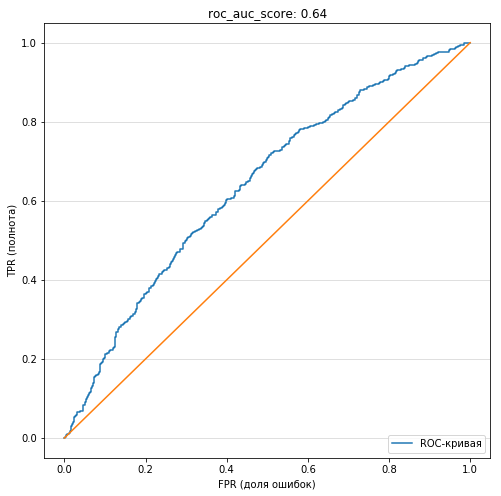

In [9]:
plt.figure(figsize = (8, 8))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label = 'ROC-кривая')
plt.plot([0, 1])
plt.xlabel('FPR (доля ошибок)')
plt.ylabel('TPR (полнота)')
plt.title('roc_auc_score: {:.2f}'.format(roc))
plt.grid(axis = 'y', alpha = 0.5)
plt.legend(loc = 4)
plt.show()